# Character-Level LSTM en PyTorch

En este notebook, vamos a construir un character-level LSTM con PyTorch. La red va se va a entrenar caracter por caracter en algun texto, luego va a generar nuevo texto por caracteres. Como ejemplo, vamos a entrenarlo en Anna Karenina. **Este modelo va a ser capaz de generar texto nuevo basado en texto del libro**

Esta red esta basada en el post de Andrej Karpathy [sobre RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) y [su implementacion en Torch](https://github.com/karpathy/char-rnn). Debajo esta la arquitectura general de un character-wise RNN.

<img src="../assets/charseq.jpeg" width="500">

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

## Cargar la data

Primero, vamos a cargar el archivo de texto de Anna Karenina y convertirlo a enteros para ser usado por nuestra red.

In [2]:
# open text file and read in data as `text`
with open('../data/anna.txt', 'r') as f:
    text = f.read()

Miremos los primeros 100 caracteres, para asegurarnos que leimos bien la data. De acuerdo a , [American Book Review](http://americanbookreview.org/100bestlines.asp) esta es la 6ta mejor primera linea de un libro.

In [3]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

### Tokenization

En las celdas de abajo, vamos a crear un par de **dictionaries** para convertir los caracteres a enteros y de regreso a caracteres. Codificar los caracteres como enteros hace mas facil usarlos como input a una red.

In [4]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text)) # hace unicos los elementos de la lista
int2char = dict(enumerate(chars)) #crear un diccionario y le pone un valor unico
char2int = {ch: ii for ii, ch in int2char.items()} #referencia el diccionario previamente 
#hecho para convertir los valores originales de letras a su referencia en numeros

# encode the text
encoded = np.array([char2int[ch] for ch in text])

Podemos ver los mismos caracteres de arriba, codificados como enteros.

In [5]:
encoded[:100]

array([33, 52, 72, 10, 78, 71, 56, 12, 17, 47, 47, 47, 82, 72, 10, 10, 76,
       12, 51, 72, 24, 40, 31, 40, 71, 73, 12, 72, 56, 71, 12, 72, 31, 31,
       12, 72, 31, 40, 50, 71, 13, 12, 71, 65, 71, 56, 76, 12, 46, 68, 52,
       72, 10, 10, 76, 12, 51, 72, 24, 40, 31, 76, 12, 40, 73, 12, 46, 68,
       52, 72, 10, 10, 76, 12, 40, 68, 12, 40, 78, 73, 12, 21, 34, 68, 47,
       34, 72, 76, 49, 47, 47,  1, 65, 71, 56, 76, 78, 52, 40, 68])

## Pre-procesamiento de la data

Como pueden ver en la imagen del char-RNN arriba, nuestro modelo espera un input que es **one-hot encoded** lo que quiere decir que cada caracter es convertido a un entero (a traves del diccionario que creamos) y _luego_ convertido a un vector columna donde solo su indice entero correspondiente va a tener el valor de 1 y el resto del vector va a estar lleno de 0's. Hagamos una funcion para hacer el one-hot:

In [6]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [7]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


## Hacer los mini-batches para entrenamiento


Para entrenar en esta data, tambien necesitamos crear mini-batches para entrenamiento. Recuerden que queremos que nuestros batches sean multiples secuencias de un numero deseado de pasos. Considerando un ejemplo simple, nuestros batches se verian de esta forma:

<img src="../assets/sequence_batching@1x.png" width=500px>

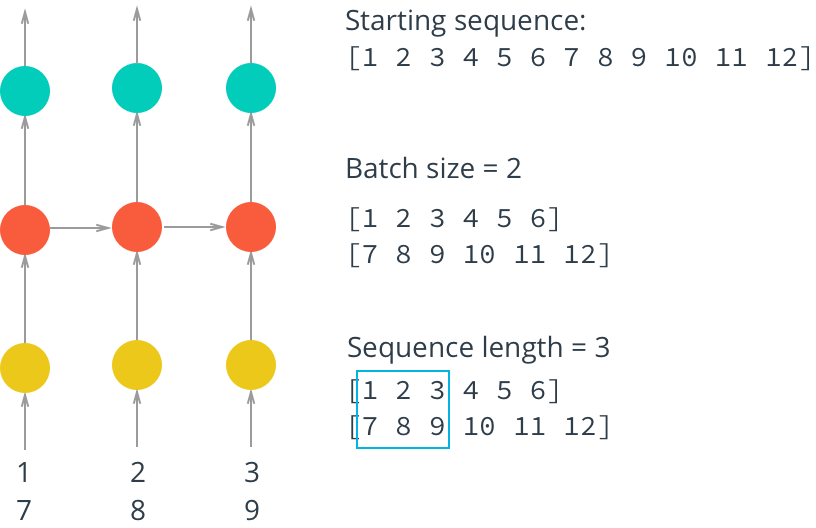
<br>


En este ejemplo, vamos a tomar los caracteres codificados (ingresados como el parametro `arr`) y partirlos en multpiles secuencias, dadas por el `batch_size`. Cada una de nuestras secuencias va a ser de largo `seq_length`.

### Creando Batches

**1. Lo primero que tenemos que hacer es descartar partes del texto para tener unicamente mini-batches completamente llenos.**

Cada batch contiene $N \times M$ caracteres, donde $N$ es el batch size (el numero de secuencias en un batch) y $M$ es el `seq_length` o numero de time steps en una sequencia. Luego, para obtener el numero total de batches, $K$ que podemos hacer del array `arr`, dividimos el length de `arr` por el numero de caracteres por batch. Una vez sabemos el numero de batches, podemos obtener el numero total de caracteres que mantendremos de `arr`, $N * M * K$.

**2. Luego, necesitamos partir `arr` en $N$ batches.**

Podemos hacer esto usando `arr.reshape(size)` donde `size` es un tuple que contiene las dimensiones del array luego del reshape. Sabemos que queremos $N$ secuencias en un batch, asi que hagamos eso el tamanio de nuestra primera dimension. Para la segunda dimension, podemos usar `-1` como un placeholder en el `size`, esto va a llenar el array con la data apropiada por si solo. Despues, deberiamos tener un array que sea $N \times (M * K)$.

**3. Ahora que tenemos este array, podemos iterar a traves de el para obtener nuestros mini-batches.**

La idea es que cada batch es una ventana $N \times M$ en el array $N \times (M * K)$. Para cada batch subsecuente, la ventana se mueve por `seq_length`. Tambien queremos crear los arrays para el input y el target. Recuerden que los targets son solo los inputs corridos por un caracter. Mi preferencia personal para hacer esta ventana es usar `range` para tomar pasos de tamanio `n_steps` de $0$ a `arr.shape[1]`, el numero total de tokens en cada secuencia. De esa forma, los enteros que obtenemos de `range` siempre apuntan al principio de un batch, y cada ventana es `seq_length` wide.


> **TODO:** Escriban el codigo para crear batches en la funcion de abajo. Los ejercicios en estos notebooks _no van a ser faciles_. No se preocupen si se traban o se tardan, sigan intentando. 

In [8]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    batch_size_total = batch_size * seq_length
    # total number of batches we can make, // integer division, round down
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    
    ## TODO: Get the number of batches we can make
    #n_batches = int(arr.shape[0]/(batch_size*seq_length))*batch_size*seq_length
    
    ## TODO: Keep only enough characters to make full batches
    #arr = arr[:,n_batches]
    
    ## TODO: Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    ## TODO: Iterate over the batches using a window of size seq_length
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y 

### Prueben su implementacion

Now I'll make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 8 and 50 sequence steps.

Vamos a crear unos data sets y podemos revisar que esta pasando mientras hacemos los batches de data. Aqui, como ejemplo, vamos a usar un batch size de 8 y 50 pasos.

In [9]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

In [10]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[33 52 72 10 78 71 56 12 17 47]
 [73 21 68 12 78 52 72 78 12 72]
 [71 68  3 12 21 56 12 72 12 51]
 [73 12 78 52 71 12 55 52 40 71]
 [12 73 72 34 12 52 71 56 12 78]
 [55 46 73 73 40 21 68 12 72 68]
 [12  2 68 68 72 12 52 72  3 12]
 [43 26 31 21 68 73 50 76 49 12]]

y
 [[52 72 10 78 71 56 12 17 47 47]
 [21 68 12 78 52 72 78 12 72 78]
 [68  3 12 21 56 12 72 12 51 21]
 [12 78 52 71 12 55 52 40 71 51]
 [73 72 34 12 52 71 56 12 78 71]
 [46 73 73 40 21 68 12 72 68  3]
 [ 2 68 68 72 12 52 72  3 12 73]
 [26 31 21 68 73 50 76 49 12 20]]


Si implementaron `get_batches` correctamente, el output de arriba deberia verse algo como
```
x
 [[25  8 60 11 45 27 28 73  1  2]
 [17  7 20 73 45  8 60 45 73 60]
 [27 20 80 73  7 28 73 60 73 65]
 [17 73 45  8 27 73 66  8 46 27]
 [73 17 60 12 73  8 27 28 73 45]
 [66 64 17 17 46  7 20 73 60 20]
 [73 76 20 20 60 73  8 60 80 73]
 [47 35 43  7 20 17 24 50 37 73]]

y
 [[ 8 60 11 45 27 28 73  1  2  2]
 [ 7 20 73 45  8 60 45 73 60 45]
 [20 80 73  7 28 73 60 73 65  7]
 [73 45  8 27 73 66  8 46 27 65]
 [17 60 12 73  8 27 28 73 45 27]
 [64 17 17 46  7 20 73 60 20 80]
 [76 20 20 60 73  8 60 80 73 17]
 [35 43  7 20 17 24 50 37 73 36]]
 ```
 aunque los numeros exactos sean diferentes. Asegurense que la data este corrida un paso para `y`.

---
## Definiendo la red con PyTorch

Abajo es donde deben definir la red.

<img src="../assets/charRNN.png" width=500px>

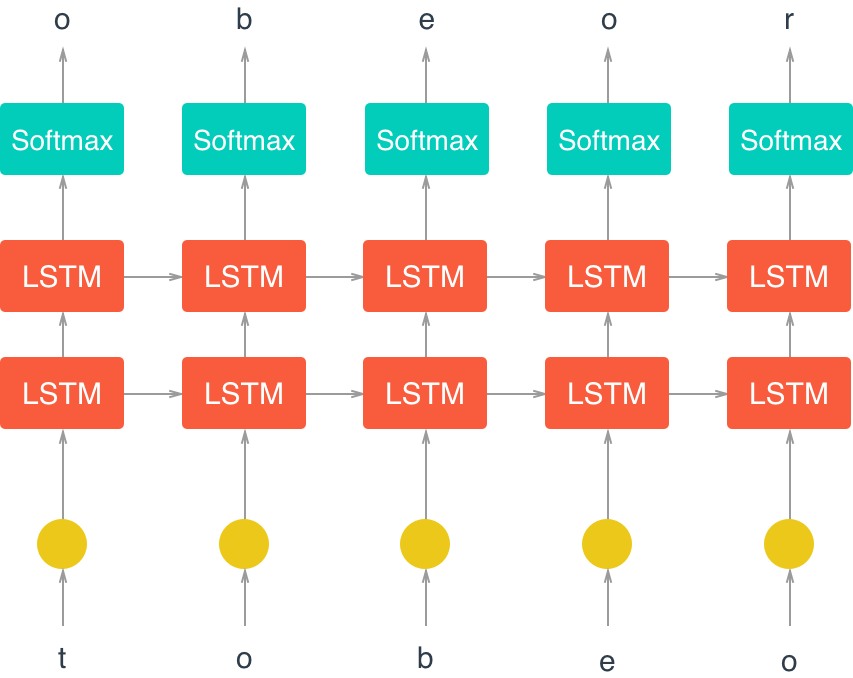

Luego, van a usar PyTorch para definir la arquitectura de la red. Empezamos definiendo los layers y operaciones que queremos. Despues, definimos el metodo para el forward pass. Tambien tienen un metodo para predecir caracteres.

### Estructura del modelo

En `__init__` la estructura sugerida es la siguiente:
* Crear y almacenar los diccionarios necesarios (esto ya esta hecho)
* Definir un layer LSTM que tomo como params: un input size (el numero de caracteres), un hidden layer size `n_hidden`, un numero de layers `n_layers`, una probabilidad de dropout `drop_prob`, y un booleano `batch_first` (True, ya que estamos batching)
* Definir un dropout layer con `drop_prob`
* Definir un fully-connected layer con params: input size `n_hidden` y output size (el numero de caracteres)
* Finalmente, inicializar los pesos (de nuevo, esto ya esta hecho)

Noten que algunos parametros han sido nombrados y dados en la funcion `__init__`, y los usamos y almacenamos haciendo algo como `self.drop_prob = drop_prob`

---
### LSTM Inputs/Outputs

Pueden crar un [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) de la siguiente forma:

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```
donde `input_size` es el numero de caracteres que este cell espera ver como input secuencial y `n_hidden` es el numero de unidades en los hidden layers en la cell. Podemos agregar dropout agregando un parametro dropout con una probabilidad especificada; esto automaticamente va a agregar dropout a los inputs o outputs. Finalmente, en la funcion `forward`, podemos apilar las LSTM cells en layers usando `.view`. Con esto, pasamos una lista de cells y va a enviar el ouput de una cell a la siguiente cell.

Tambien tenemos que crear un hidden state inicial de todos ceros. Esto se hace de la siguiente forma:

```python
self.init_hidden()
```

In [11]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [12]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the layers of the model
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(n_hidden, len(self.chars))
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.fc(out)        
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

## Hora de entrenar

La funcion de train nos da la habilidad de establecer el numero de epochs, el learning rate y otros parametros.

Abajo estamos usando el optimizador Adam y cross entropy loss ya que estamos viendo los scores de las clases de caracteres como output. Podemos calcular el loss y realizar backpropagation como siempre.

Un par de detalles sobre el training:
>* Dentro del loop de batch, hacemos detach del hidden state de su historia; esta vez lo hacemos asignandolo a una nueva variable (un tuple) porque un LSTM tiene un hidden state que es un tuple de hidden y cell states.

* Usamos [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) para prevenir exploding gradients.

In [13]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

## Inicializando el modelo

Ahora podemos entrenar la red. Primero tenemos que crear la red en si, con sus hiper parametros. Luego, definir el tamanio de los mini-batches.

In [14]:
## TODO: set your model hyperparameters
# define and print the net
n_hidden=512
n_layers=4

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(83, 512, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


### Inicializar los hiper parametros de entrenamiento!

In [16]:
batch_size = 64
seq_length = 50
n_epochs = 20

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/20... Step: 10... Loss: 3.1394... Val Loss: 3.1270
Epoch: 1/20... Step: 20... Loss: 3.0731... Val Loss: 3.1275
Epoch: 1/20... Step: 30... Loss: 3.1047... Val Loss: 3.1290
Epoch: 1/20... Step: 40... Loss: 3.1081... Val Loss: 3.1271
Epoch: 1/20... Step: 50... Loss: 3.1227... Val Loss: 3.1287
Epoch: 1/20... Step: 60... Loss: 3.1151... Val Loss: 3.1276
Epoch: 1/20... Step: 70... Loss: 3.1242... Val Loss: 3.1281
Epoch: 1/20... Step: 80... Loss: 3.0941... Val Loss: 3.1271
Epoch: 1/20... Step: 90... Loss: 3.1554... Val Loss: 3.1273
Epoch: 1/20... Step: 100... Loss: 3.1109... Val Loss: 3.1273
Epoch: 1/20... Step: 110... Loss: 3.1319... Val Loss: 3.1276
Epoch: 1/20... Step: 120... Loss: 3.1134... Val Loss: 3.1294
Epoch: 1/20... Step: 130... Loss: 3.1178... Val Loss: 3.1286
Epoch: 1/20... Step: 140... Loss: 3.1374... Val Loss: 3.1283
Epoch: 1/20... Step: 150... Loss: 3.1403... Val Loss: 3.1293
Epoch: 1/20... Step: 160... Loss: 3.1242... Val Loss: 3.1289
Epoch: 1/20... Step: 170... Loss:

KeyboardInterrupt: 

## Obteniendo el mejor modelo

Para elegir los hiper parametros para obtener el mejor desempenio, hay que ponerle atencion al training y validation loss. Si el training loss es mucho mas bajo que el validation loss, estamos overfitting. En ese caso hay que incrementar la regularizacion (mas dropout) o usar una red mas pequenia. Si el training y validation loss estan cerca, estamos underfitting. En este caso, hay que incrementar el tamanio de la red.

## Hiperparametros

Aqui estan los hiperparametros para la red.

Al definir el modelo:
* `n_hidden` - Numero de unidades en los hidden layers.
* `n_layers` - Numero de hidden LSTM layers para usar.

En este ejemplo asumimos que la probabilidad de dropout y el learning rate se van a mantener en sus defaults.

en entrenamiento:
* `batch_size` - Numero de secuencias corriendo a traves de la red en un forward pass.
* `seq_length` - Numero de caracteres en la secuencia en la que la red esta siendo entrenada. Normalmente mas larga es mejor, la red va a aprender dependencias de rangos mas largos. Pero toma mas tiempo para entrenar. 100 es un buen numero aqui. 
* `lr` - Learning rate para entrenamiento.

Aqui pueden leer buenos consejos de Andrej Karpathy para entrenar la red. Lo voy a copy paste para su beneficio, pero tambien proveo el link [de donde originalmente vino](https://github.com/karpathy/char-rnn#tips-and-tricks). A continuacion el copy paste:

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `n_hidden` and `n_layers`. I would advise that you always use `n_layers` of either 2/3. The `n_hidden` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `n_hidden` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

## Checkpoint

Luego de entrenar, vamos a guardar el modelo para poder cargarlo mas tarde si lo necesitamos. Estamos guardando los parametros necesitados para crear la misma arquitectura, los hiperparametros del hidden layer y los caracteres del texto.

In [ ]:
# change the name, for saving multiple files
model_name = 'rnn_x_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

---
## Haciendo predicciones

Ahora que el modelo esta entrenado, vamos a querer muestrear de el y hacer predicciones sobre caracteres. Para muestrear, pasamos un caracter y hacemos que el modelo prediga el siguiente caracter. Luego tomamos ese caracter, lo metemos de nuevo, y obtenemos otro caracter predecido. Hacemos esto varias veces para generar mas texto.

### Una nota sobre la funcion `predict`

El output de nuestra RNN es de una fully-connected layer y saca una **distribucion de scores para el siguiente caracter**

> Para sacar el siguiente caracter, aplicamos una funcion softmax, la cual nos da una distribucion de _probabilidades_ del cual podemos muestrear para predecir el siguiente caracter.

### Top K sampling

Nuestras predicciones vienen de una distribucion de probabilidades categoricas sobre todos los posibles caracteres. Podemos hacer el texto de la muestra y hacerlo mas facil de manejar (con menos variables) considerando unicamente algunos $K$ caracteres mas probables. Esto va a prevenir que la red nos de caracteres completamente absurdos y a la vez permitir que la red introduzca un poco de ruido y randomness al texto muestrado. Pueden leer mas sobre [topk, aqui](https://pytorch.org/docs/stable/torch.html#torch.topk).


In [ ]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

### Priming y generando texto

Normalmente vamos a querer prime a la red para poder construir su hidden state. De lo contrario la red va a empezar generando caracteres de forma aleatoria. En general el primer monton de caracteres va a ser mas malo ya que no ha construido una historia suficientemente larga de caracteres de los cuales puede formar predicciones.

In [ ]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [ ]:
print(sample(net, 1000, prime='Anna', top_k=5))

## Cargando un checkpoint

In [ ]:
# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('rnn_x_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

In [ ]:
# Sample using a loaded model
print(sample(loaded, 2000, top_k=5, prime="And Levin said"))